# Classifying images of everyday objects using a neural network
The ability to try many different neural network architectures to address a problem is what makes deep learning really powerful, especially compared to shallow learning techniques like linear regression, logistic regression etc.

In [ ]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [ ]:
import os
import tarfile
import torch
import numpy as np

import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

import torch.nn as nn
from torch.nn import AvgPool2d
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

!pip install torchsummary
from torchsummary import summary
from torchvision.utils import make_grid
import torch.optim as optim

## Exploring the Data
We'll download the images in PNG format from the following link, using some helper functions from the torchvision and tarfile packages.

In [ ]:
# Dowload the dataset
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [ ]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

The dataset is extracted to the directory data/cifar10. It contains 2 folders train and test, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using os.listdir.

In [ ]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test', 'labels.txt']
['deer', 'airplane', 'horse', 'truck', 'frog', 'ship', 'cat', 'dog', 'bird', 'automobile']


In [ ]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['29505_airplane.png', '18861_airplane.png', '10323_airplane.png', '36374_airplane.png', '2264_airplane.png']


In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                              transforms.RandomHorizontalFlip(),
                                              #transforms.RandomAffine(degrees=10, shear = 10),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*stats, inplace=True)
                                              #transforms.Normalize([0.4914,0.4822,0.4465], [0.247, 0.243, 0.261])
                                              ])

transform_test = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(*stats, inplace=True)
                                            #transforms.Normalize([0.4914,0.4822,0.4465], [0.247, 0.243, 0.261])
                                            ])

In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=transform_train)
val_dataset = ImageFolder(data_dir+'/test', transform=transform_test)

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[1.8744, 1.8356, 1.8162,  ..., 1.8744, 1.8356, 1.8162],
         [1.9132, 1.8938, 1.8550,  ..., 1.9132, 1.8744, 1.8356],
         [1.9132, 1.8938, 1.8550,  ..., 1.8938, 1.8550, 1.8162],
         ...,
         [2.1264, 2.0682, 2.0295,  ..., 2.1652, 2.1458, 2.0682],
         [1.9132, 1.8744, 1.7968,  ..., 2.1458, 2.1264, 2.0489],
         [1.4867, 1.3898, 1.2735,  ..., 2.1458, 2.1070, 2.0489]],

        [[2.3215, 2.2821, 2.2625,  ..., 2.2428, 2.2428, 2.2035],
         [2.3608, 2.3411, 2.3018,  ..., 2.2821, 2.2821, 2.2428],
         [2.3608, 2.3411, 2.3018,  ..., 2.2625, 2.2625, 2.2231],
         ...,
         [2.4001, 2.3805, 2.3805,  ..., 2.3215, 2.3215, 2.3215],
         [2.2428, 2.2231, 2.1445,  ..., 2.3018, 2.3018, 2.3018],
         [1.8298, 1.7314, 1.6134,  ..., 2.3018, 2.2821, 2.2821]],

        [[2.6172, 2.5781, 2.5586,  ..., 2.5586, 2.5586, 2.5196],
         [2.6562, 2.6367, 2.5976,  ..., 2.5781, 2.5976, 2.5586],
         [2.6562, 2.6367, 2.5976,  ..., 2.5586, 2.5781, 2.

In [ ]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  airplane (0)


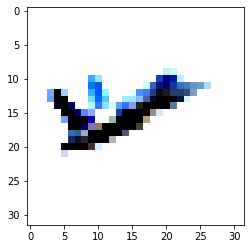

In [ ]:
show_example(*dataset[0])

In [ ]:
batch_size=400

train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


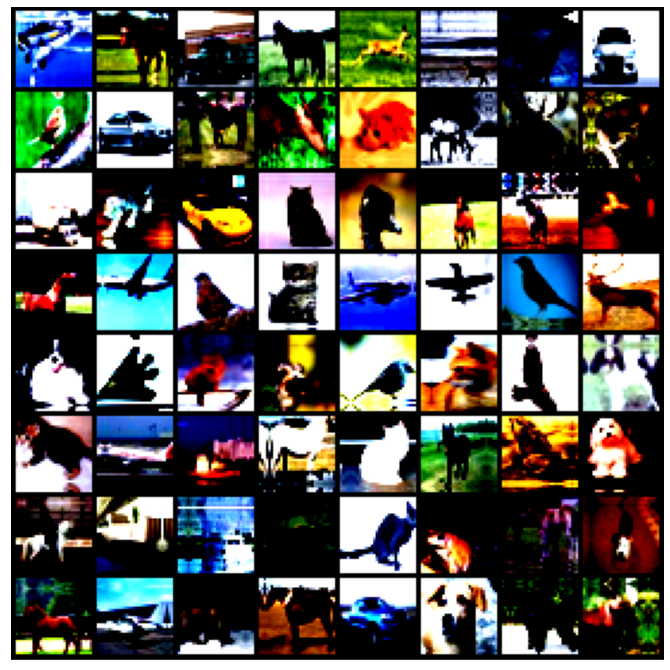

In [ ]:
show_batch(train_dl)

Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

We'll use nn.Sequential to chain the layers and activations functions into a single network architecture.

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),


            nn.Conv2d(256, 32, kernel_size=1, stride=1, padding=0),
            nn.MaxPool2d(2, 2), # output: 32 x 14 x 14
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
           
            nn.Conv2d(256, 10, kernel_size=1, stride=1, padding=0),

            nn.AvgPool2d(kernel_size=8),           
            nn.Flatten(),
            nn.Softmax(dim=1))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Dropout(p=0.1, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(32, 64, kernel_size=(

In [ ]:
print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

788586
788586


In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([400, 3, 32, 32])
out.shape: torch.Size([400, 10])
out[0]: tensor([0.1303, 0.0803, 0.0587, 0.1888, 0.1465, 0.0871, 0.0702, 0.0456, 0.0839,
        0.1086], grad_fn=<SelectBackward>)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
#test_dl = DeviceDataLoader(test_dl, device)

model = to_device(Cifar10CnnModel(), device)

In [ ]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 30, 30]          73,856
       BatchNorm2d-9          [-1, 128, 30, 30]             256
             ReLU-10          [-1, 128, 30, 30]               0
          Dropout-11          [-1, 128, 30, 30]               0
           Conv2d-12          [-1, 256, 28, 28]         295,168
      BatchNorm2d-13          [-1, 256, 28, 28]             512
             ReLU-14          [-1, 256,

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.09615384787321091, 'val_loss': 2.302446126937866}]

In [ ]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 2.1029, val_loss: 2.0175, val_acc: 0.4535
Epoch [1], train_loss: 1.9501, val_loss: 1.8927, val_acc: 0.5836
Epoch [2], train_loss: 1.8771, val_loss: 1.8436, val_acc: 0.6230
Epoch [3], train_loss: 1.8412, val_loss: 1.8464, val_acc: 0.6156
Epoch [4], train_loss: 1.8185, val_loss: 1.8635, val_acc: 0.5973
Epoch [5], train_loss: 1.8005, val_loss: 1.8370, val_acc: 0.6235
Epoch [6], train_loss: 1.7865, val_loss: 1.9226, val_acc: 0.5367
Epoch [7], train_loss: 1.7799, val_loss: 1.8282, val_acc: 0.6358
Epoch [8], train_loss: 1.7765, val_loss: 1.9754, val_acc: 0.4815
Epoch [9], train_loss: 1.7757, val_loss: 1.8342, val_acc: 0.6253
Epoch [10], train_loss: 1.7713, val_loss: 1.7968, val_acc: 0.6644
Epoch [11], train_loss: 1.7676, val_loss: 1.8608, val_acc: 0.5968
Epoch [12], train_loss: 1.7744, val_loss: 1.7977, val_acc: 0.6628
Epoch [13], train_loss: 1.7722, val_loss: 1.8485, val_acc: 0.6126
Epoch [14], train_loss: 1.7745, val_loss: 1.7792, val_acc: 0.6819
Epoch [15], train_lo

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

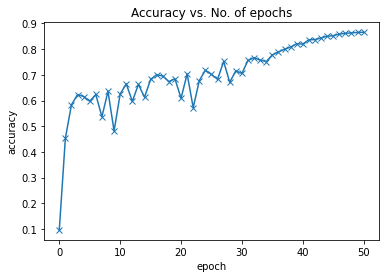

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

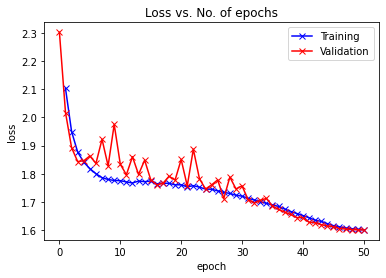

In [ ]:
plot_losses(history)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point!
![alt text](https://i.stack.imgur.com/1QU0m.png)
This phenomenon is called overfitting, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.

Following are some common stragegies for avoiding overfitting:

Gathering and generating more training data, or adding noise to it
Using regularization techniques like batch normalization & dropout
Early stopping of model's training, when validation loss starts to increase

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

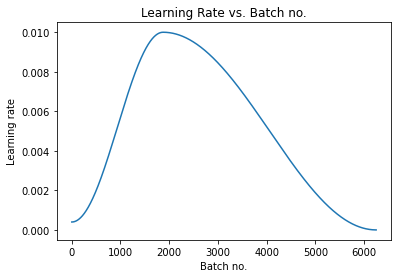

In [ ]:
plot_lrs(history)

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')